In [1]:
import scanpy as sc
from torch.utils import data

import pandas as pd
import torch
import torch.optim as optim
import os
import sys
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
from scInferCode.model import ContrastiveNetwork
from scInferCode.model import ContrastiveLoss
from scInferCode.utils import make_paired_samples
from scInferCode.utils import make_scInfer_dataset
from scInferCode.utils import train_embeddings
from scInferCode.utils import make_embeddings


In [4]:
rna = sc.read_h5ad('./scInferData/BreastTask/rna.h5ad')
protein = sc.read_h5ad('./scInferData/BreastTask/protein.h5ad')

In [5]:
sample_df = make_paired_samples(rna, protein)

Counts of all celltype:
              count
celltype          
macrophage     130
monocyte       130
epithelial     139
mesenchymal    131
neg_samples:60000, pos_samples:60000


In [6]:
train_dataset, valid_dataset, rna_df, protein_df = make_scInfer_dataset(rna, protein, sample_df, rna_vars='highly_variable', protein_vars='importance', test_size=0.3, random_state=2024)

## 开始训练

In [7]:
input_size = train_dataset.get_size()
batch_size = 512
hidden_size = 256
embedding_size = 32
num_epochs = 100
margin = 1.0
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model = ContrastiveNetwork(input_size, hidden_size, embedding_size).to(device)
criterion = ContrastiveLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size, shuffle=False)

In [10]:
input_size

{'protein': 127, 'rna': 2529}

In [11]:
device

device(type='cuda')

lr: 0.000900
epoch:0| Train Loss: 0.00011907619311075125 | Test Loss: 4.6712028638770184e-05
epoch:1| Train Loss: 2.6719739483225914e-05 | Test Loss: 1.878569229868137e-05
epoch:2| Train Loss: 1.3709024991840124e-05 | Test Loss: 1.1615693983104495e-05
epoch:3| Train Loss: 9.944446418168289e-06 | Test Loss: 9.83235154611369e-06
epoch:4| Train Loss: 8.239068451248818e-06 | Test Loss: 8.495448493502206e-06
epoch:5| Train Loss: 5.60844590100238e-06 | Test Loss: 6.7767087732338245e-06
epoch:6| Train Loss: 4.641903231718711e-06 | Test Loss: 6.9110142131749955e-06
epoch:7| Train Loss: 4.043550854216197e-06 | Test Loss: 7.585731716567857e-06
epoch:8| Train Loss: 3.625875860702113e-06 | Test Loss: 5.909687841065331e-06
epoch:9| Train Loss: 4.183431580756968e-06 | Test Loss: 6.604388352975042e-06
lr: 0.000810
epoch:10| Train Loss: 4.9746552748339515e-06 | Test Loss: 5.941870185779408e-06
epoch:11| Train Loss: 2.977062614739961e-06 | Test Loss: 6.41185501525696e-06
epoch:12| Train Loss: 2.2791136

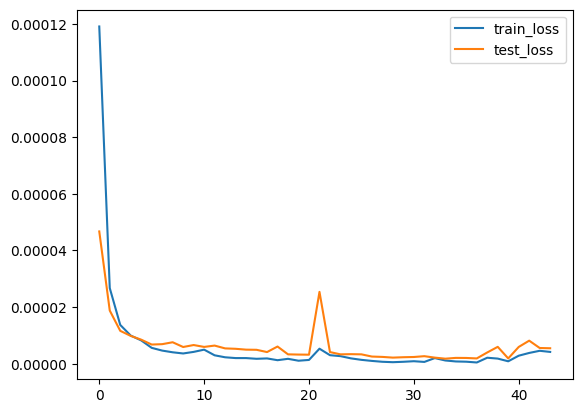

In [12]:
model = train_embeddings(num_epochs, optimizer, device, model, criterion, train_loader, test_loader)

### 加载训练好的模型

In [13]:
model_path = f'./scInferData/ModelParams/BreastTask2024.pth'

In [14]:
torch.save(model.state_dict(), model_path)

In [15]:
model = ContrastiveNetwork(input_size, hidden_size, embedding_size).to(device)

In [16]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [17]:
model.eval()

ContrastiveNetwork(
  (protein_branch): Sequential(
    (0): Linear(in_features=127, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (rna_branch): Sequential(
    (0): Linear(in_features=2529, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
)

In [18]:
rna_em_ann, protein_em_ann = make_embeddings(model, device, rna_df, protein_df, rna, protein, celltype_key = 'celltype')

In [19]:
rna_em_ann.write('./scInferData/BreastTask/rna_embeddings.h5ad')
protein_em_ann.write('./scInferData/BreastTask/protein_embeddings.h5ad')

### 初步验证嵌入能力

In [20]:
sc.tl.tsne(protein_em_ann, metric='cosine')

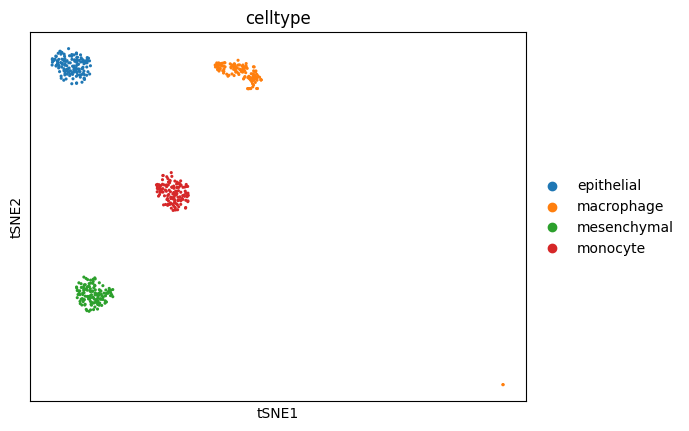

In [21]:
sc.pl.tsne(protein_em_ann, color='celltype', size=20)

In [22]:
sc.pp.pca(protein)

In [23]:
sc.tl.tsne(protein)

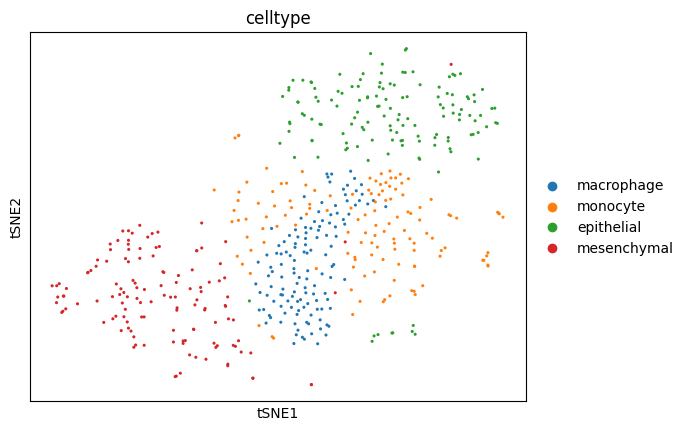

In [24]:
sc.pl.tsne(protein, color='celltype', size=20)

In [25]:
sc.tl.pca(rna)

In [26]:
sc.tl.tsne(rna)

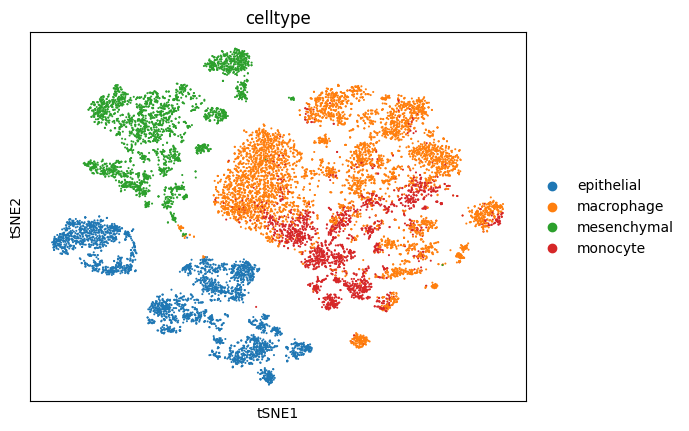

In [27]:
sc.pl.tsne(rna, color=['celltype'])

In [28]:
sc.tl.pca(rna_em_ann)

In [29]:
sc.tl.tsne(rna_em_ann, metric='cosine')

In [30]:
rna_em_ann

AnnData object with n_obs × n_vars = 13728 × 32
    obs: 'celltype'
    uns: 'pca', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

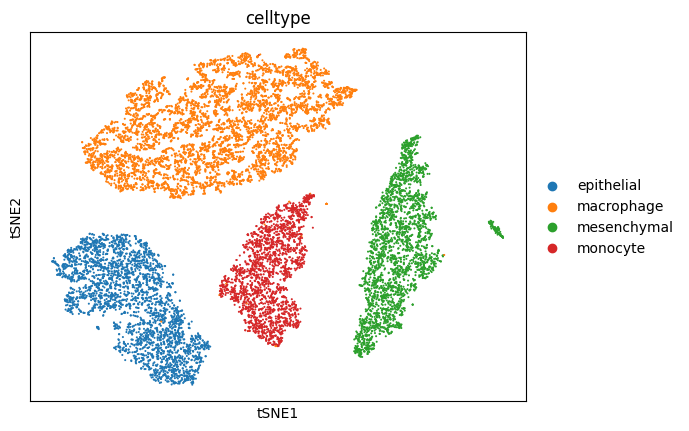

In [31]:
sc.pl.tsne(rna_em_ann, color='celltype')  